# Классичесское машинное обучение

## Место для импорта библиотек

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

## Загрузка и предобработка данных

Общая информация: 

Вам дана таблица bank_clients_data.csv содержащая данные о клиентах банка.<br>Необходимо решить задачу классификации, покинул клиент банк или нет. <br>
Поля таблицы:

* RowNumber — соответствует номеру записи (строки)
* СustomerId — id клиента;
* Surname — фамилия клиента;
* CreditScore — крдитный рейтиинг клиента, полученный в результате каких-то расчетов внутри банка;
* Geography — местоположение клиента;
* Gender — пол;
* Age — возраст;
* Tenure — количество лет, в течение которых человек является клиентом банка;
* Balance — остаток на счете;
* NumOfProducts — количество продуктов, которые клиент приобрел через банк;
* HasCrCard — есть ли у клиента кредитная карта. 1-да, 0-нет;
* IsActiveMember — активный-1 или нет-2 клиент;
* EstimatedSalary — заработная плата;
* Exited — перестал ли клиент пользоваться услугами банка и в принципе быть его лкиентом. Целевая переменная. Характеризует отток.


## 1. EDA. Составьте Общее представление о данных

#### 1. Прочитайте таблицу и выведите информацию о каждом столбце (среднее значение, среднее отклонение, основные процентили итп)

In [2]:
data = pd.read_csv('bank_clients_data.csv', index_col ='RowNumber')
data.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


#### 2. Чему равен 80% процентиль по полю зарплаты, результат округлите до 1 знака после запятой, о чём говорит данное значение?

In [3]:
round(data["EstimatedSalary"].quantile(0.8, interpolation='linear'), 1)

159836.7

Это означает, что 80% зарплат меньше или равны 159836.7, а 20% зарплат больше этого значения.

#### 3. Есть ли в данных пропущенные значения?

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
data.isnull().sum().sum()

0

Пропущенных значений нет

#### 4. Проверьте сбалансированность классов и сделайте вывод 


In [6]:
data['Exited'].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

Из предоставленных данных видно, что классы несбалансированы.

Количество примеров для класса 0 (не ушли) составляет 7963, в то время как количество примеров для класса 1 (ушли) составляет всего лишь 2037.

Такое неравенство в количестве примеров может привести к проблемам при обучении модели, особенно если алгоритм классификации чувствителен к несбалансированным данным. В таких случаях могут быть применены различные методы балансировки классов, такие как взвешивание классов, аугментация данных меньшего класса или использование алгоритмов, способных работать с несбалансированными данными (например, алгоритмы случайного леса или градиентного бустинга с автоматической обработкой несбалансированных классов).

## 2. Построение графиков 

#### 1. Постройте гистограмму распределения возраста клиентов, сделайте ее зеленого цвета, не забудьте про наименования осей и самого графика

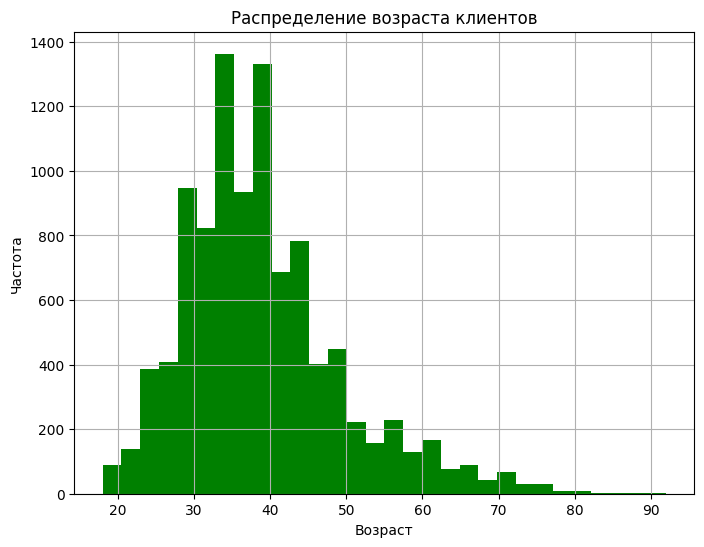

In [7]:
plt.figure(figsize=(8, 6))
plt.hist(data.Age, color='green', bins=30)
plt.title('Распределение возраста клиентов')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.grid(True)

plt.show()

#### 2. Постройте график распределения количества ушедших клиентов исходя из их пола. Наверху каждого столбца отобразите количественный показатель. Какой можно сделать вывод?

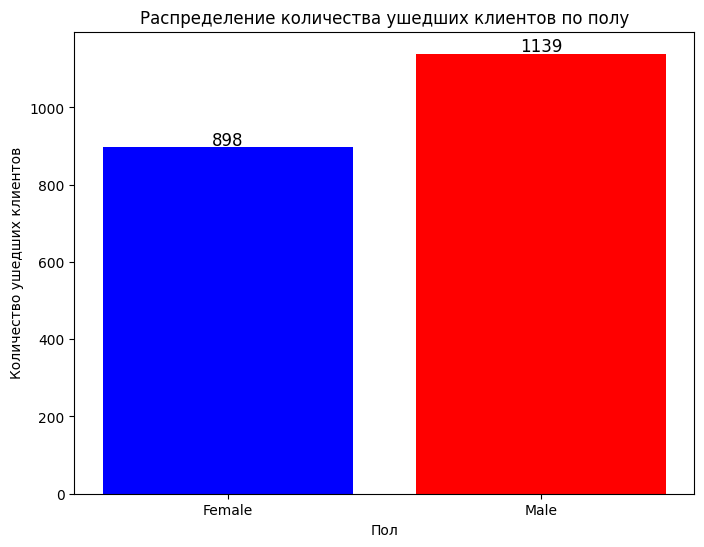

In [8]:
plt.figure(figsize=(8, 6))
plt.bar(data.Gender.unique(), [data[data.Exited == 1].Gender.value_counts()['Male'], data[data.Exited == 1].Gender.value_counts()['Female']], color=['blue', 'red'])

for i in range(len(data.Gender.unique())):
    plt.text(i, [data[data.Exited == 1].Gender.value_counts()['Male'], data[data.Exited == 1].Gender.value_counts()['Female']][i] + 5, str([data[data.Exited == 1].Gender.value_counts()['Male'], data[data.Exited == 1].Gender.value_counts()['Female']][i]), ha='center', fontsize=12)

plt.title('Распределение количества ушедших клиентов по полу')
plt.xlabel('Пол')
plt.ylabel('Количество ушедших клиентов')

plt.show()

#### 3. Возьмите данные о географии клиентов и их доходах. Постройте круговую диаграмму, отображающую картину среднего заработка по странам (должны быть видны страны и конкретные числовые значения)

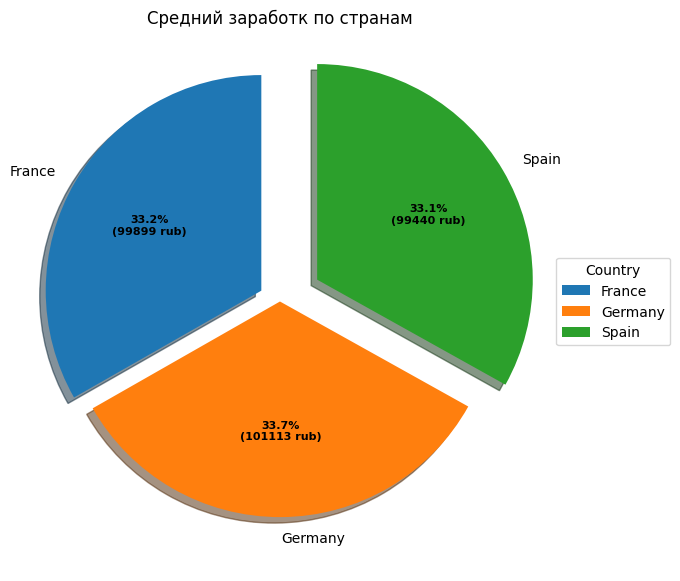

In [9]:
country = data.groupby('Geography')['EstimatedSalary'].mean().index
salary = data.groupby('Geography')['EstimatedSalary'].mean().values

explode = (0.1, 0.0, 0.2)

def func(pct, allvalues):
	absolute = int(pct / 100.*np.sum(allvalues))
	return "{:.1f}%\n({:d} rub)".format(pct, absolute)


# Creating plot
fig, ax = plt.subplots(figsize=(10, 7))
wedges, texts, autotexts = ax.pie(salary,
								autopct=lambda pct: func(pct, salary),
								explode=explode,
								labels=country,
								shadow=True,
								startangle=90)

ax.legend(wedges, country,
		title="Country",
		loc="center left",
		bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=8, weight="bold")
ax.set_title("Средний заработк по странам")

plt.show()

#### 4. Постройте тепловую карту корреляции всех признаков из таблицы. Согласно полученной карте, какие признаки показывают наибольшую взаимосвязь? 

In [10]:
label_encoder = LabelEncoder()
data['Geography'] = label_encoder.fit_transform(data['Geography'])
data['Gender'] = label_encoder.fit_transform(data['Gender'])
data['Surname'] = label_encoder.fit_transform(data['Surname'])

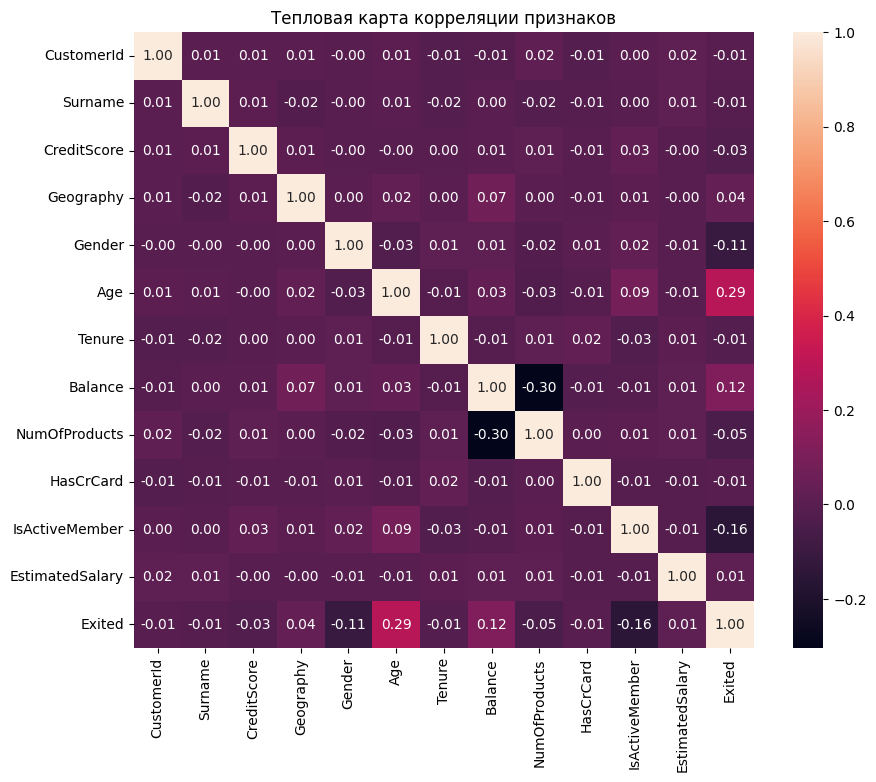

In [11]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, fmt=".2f")
plt.title('Тепловая карта корреляции признаков')
plt.show()

## 3. Подготовка данных к использованию в алгоритмах ml

####  1. Избавьтесь от полей, которые по вашему мнению являются неинформативными, поясните выбор

In [12]:
data = data.drop(columns=['CustomerId', 'Surname'])

#### 2. Переведите категориальные данные в числовые. 

Было сделано выше.


In [13]:
# label_encoder = LabelEncoder()
# data['Geography'] = label_encoder.fit_transform(data['Geography'])
# data['Gender'] = label_encoder.fit_transform(data['Gender'])
# data['Surname'] = label_encoder.fit_transform(data['Surname'])

#### 3. Разделите данные на train (80%) и test (20%) любым способом

1. Для задачи линейной регрессии, целевой признак Age<br> Получите датасеты:
X_reg_train, X_reg_test, y_reg_train, y_reg_test

2. Для задачи логистической регрессии. Целевой признак Exited<br> Получите датасеты:
X_cl_train, X_cl_test, y_cl_train, y_cl_test

In [14]:
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(data.drop(columns='Age'), data.Age, test_size=0.2, random_state=42)
X_cl_train, X_cl_test, y_cl_train, y_cl_test = train_test_split(data.drop(columns='Exited'), data.Exited, test_size=0.2, random_state=42)

#### 4. Стандартизируйте данные для классификации или регресии, если это необходимо.

In [15]:
scaler = StandardScaler()
X_reg_train_scaled = scaler.fit_transform(X_reg_train)
X_reg_test_scaled = scaler.transform(X_reg_test)

In [16]:
X_cl_train_scaled = scaler.fit_transform(X_cl_train)
X_cl_test_scaled = scaler.transform(X_cl_test)

## 4. Работа с ml моделями

#### 1. Реализуйте модель линейной регрессии для поля 'Age' аналитическим способом, используя формулу весов, полученную от минимизации ошибок по методу наименьших квадратов. 

$ w = (X^TX)^{-1}X^TY $

In [17]:
# Создайте функцию, которая принимает значения выборок, полученных выше (X_reg_train, X_reg_test, y_reg_train, y_reg_test) и 
# выдаёт среднюю абсолютную ошибку и корень из среднеквадратичной ошибки по тестовой выборке

def lin_reg_1(X_tr, y_tr, X_te, y_te):
    
    X_tr = np.column_stack((np.ones(len(X_tr)), X_tr))
    X_te = np.column_stack((np.ones(len(X_te)), X_te))
    
    weights = np.linalg.inv(X_tr.T.dot(X_tr)).dot(X_tr.T).dot(y_tr)
    y_pred = np.dot(X_te, weights)
    
    mae = np.mean(np.abs(y_pred - y_te))
    mse = np.sqrt(np.mean((y_pred - y_te) ** 2))
    
    return mae, mse

In [18]:
lin_reg_1(X_reg_train_scaled, y_reg_train, X_reg_test_scaled, y_reg_test)

(7.253149739759285, 9.830993464360446)

#### 2. Реализуйте модель линейной регрессии при помощи любого готового пакета, сравните полученное mae из двух моделей, из этого решения и полученного выше. Сделайте выводы.

In [19]:
def lin_reg_sklearn(X_tr, y_tr, X_te, y_te):
    model = LinearRegression()
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    
    mae = mean_absolute_error(y_te, y_pred)
    mse = mean_squared_error(y_te, y_pred, squared=False)  
    
    return mae, mse

In [20]:
lin_reg_sklearn(X_reg_train_scaled, y_reg_train, X_reg_test_scaled, y_reg_test)

(7.253149739759286, 9.830993464360446)

#### 3. Реализуйте модель логистической регрессии для поля 'Exited'

1. Напишите функцию активации, которую в дальнейшем будете использовать. <br>
$y_{pred}(y') = \frac{1}{1 + e^{-\langle y' \rangle}}
$

In [21]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

2. Напишите функцию кроссэнтропии, проверьте работает ли она, функция не должна ничего возвращать, дальше понадобится только тело функции <br>
$L(w) = -y\, log\,y_{pred} - (1-y)\,log\,(1-y_{pred})$

In [22]:
def cross_entropy(y, y_pred):
    
    y = np.array(y)
    y_pred = np.array(y_pred)
    
    loss = -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
    print("Значение функции кросс-энтропии:", loss)

3. Дополните архитектуру логистической регрессии. Обучите и предскажите результаты по тестовой выборки раннее полученнх данных для классификации. (X_cl_train, X_cl_test, y_cl_train, y_cl_test). <br>
Выведите classification_report из пакета sklearn. Получите weighted avg >= 0.68 по каждой метрике из отчёта

In [23]:
class Hand_made_Logistic_reg:
    
    #Здесь ваша функция сигмоиды 
    def sigmoid(self, h):
        return 1 / (1 + np.exp(-h))


    def loss_function(self, X, y, weights): 
        # если смотреть на функцию потерь, то y_pred в ней это:
        y_hat = np.dot(X, weights)

        #здесь описывается функция потерь - кросс энтропия 
        # вставьте своё созданное выше выражение в скобки
        return -np.sum(y * np.log(self.sigmoid(y_hat)) + (1 - y) * np.log(1 - self.sigmoid(y_hat))) / len(X) #((не забудьте self рядом с функциями, которые определены внутри класса))

    
    def fit(self, X, y, epochs=1000, lr=0.01):      
        loss = []

        weights = np.random.rand(X.shape[1])
        N = X.shape[0] #кол-во cтрочек в датасете 
                 
        for epoch in range(epochs):        
            # Градиентный спуск:
            y_hat = self.sigmoid(np.dot(X, weights))            
            #Здесь функция обновления весов 
            #Запишите функцию обновления весов на каждом шаге, здесь пригодится lr и N
            weights -= lr * np.dot(X.T, (y_hat - y)) / N
            #Запись ошибок в список
            loss.append(self.loss_function(X, y, weights))
        
            #Отображение ошибок по эпохам во время обучения
            print('Эпоха:', epoch, 'Loss:', loss[-1])
        self.weights = weights
        self.loss = loss
     
    
    def predict(self, X):        
        # скалярное умножение весов и новых значений х
        y_hat = np.dot(X, self.weights)
        # возвращение списка значений, которые выше определенного уровня вероятности
        return [1 if x > 0.8 else 0 for x in self.sigmoid(y_hat)]

In [24]:
model = Hand_made_Logistic_reg()
model.fit(X_cl_train_scaled, y_cl_train)
y_pred = model.predict(X_cl_test_scaled)

Эпоха: 0 Loss: 1.151094881087412
Эпоха: 1 Loss: 1.1499522700453664
Эпоха: 2 Loss: 1.1488111304748645
Эпоха: 3 Loss: 1.1476714632628664
Эпоха: 4 Loss: 1.1465332692928178
Эпоха: 5 Loss: 1.1453965494446283
Эпоха: 6 Loss: 1.144261304594656
Эпоха: 7 Loss: 1.143127535615685
Эпоха: 8 Loss: 1.1419952433769094
Эпоха: 9 Loss: 1.1408644287439142
Эпоха: 10 Loss: 1.1397350925786554
Эпоха: 11 Loss: 1.138607235739441
Эпоха: 12 Loss: 1.1374808590809133
Эпоха: 13 Loss: 1.1363559634540301
Эпоха: 14 Loss: 1.1352325497060436
Эпоха: 15 Loss: 1.1341106186804832
Эпоха: 16 Loss: 1.1329901712171369
Эпоха: 17 Loss: 1.1318712081520295
Эпоха: 18 Loss: 1.130753730317407
Эпоха: 19 Loss: 1.1296377385417142
Эпоха: 20 Loss: 1.1285232336495783
Эпоха: 21 Loss: 1.1274102164617874
Эпоха: 22 Loss: 1.126298687795273
Эпоха: 23 Loss: 1.1251886484630895
Эпоха: 24 Loss: 1.124080099274395
Эпоха: 25 Loss: 1.1229730410344325
Эпоха: 26 Loss: 1.1218674745445105
Эпоха: 27 Loss: 1.120763400601983
Эпоха: 28 Loss: 1.1196608200002311
Эпо

In [25]:
print(classification_report(y_cl_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.96      0.88      1607
           1       0.42      0.12      0.19       393

    accuracy                           0.80      2000
   macro avg       0.62      0.54      0.54      2000
weighted avg       0.74      0.80      0.75      2000



#### 4. Создайте стэк из 3-х моделей, одна из которых должна быть на оcнове бустинга деревьев, другая использоваться в комплексе с жадным подбором гиперпараметров, третья любая. Также как и выше, предскажите поле "Exited". Выведите classification_report 

In [26]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
xgb = XGBClassifier(random_state=42)
grid_search = GridSearchCV(xgb, param_grid, cv=3)

estimators = [
    ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
    ('svr', LinearSVC(dual="auto", random_state=42)),
    ('xgb', grid_search)
]
stacking_clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)

stacking_clf.fit(X_cl_train_scaled, y_cl_train)
y_pred = stacking_clf.predict(X_cl_test_scaled)

print(classification_report(y_cl_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1607
           1       0.74      0.48      0.58       393

    accuracy                           0.86      2000
   macro avg       0.81      0.72      0.75      2000
weighted avg       0.86      0.86      0.85      2000

